### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib
import matplotlib.axes
import matplotlib.figure
import matplotlib.pyplot as plt
import matplotlib.ticker
import numpy as np
import pandas as pd
from statsmodels.stats.proportion import proportion_confint

import utils

# To save space in the body of our paper, we're shrinking
# the height of the plots in this notebook.
FIG_HEIGHT_MULTIPLIER = 0.7

plt.style.use(
    [
        "tableau-colorblind10",
        utils.get_style("default"),
        utils.get_style("1-col-neurips"),
        utils.get_style("small-legend"),
        {
            "ytick.minor.visible": True,
            "ytick.left": True,
            "ytick.right": True,
        },
    ]
)
utils.import_plt_sty("defense-macros.sty")
COLORS = plt.rcParams["axes.prop_cycle"].by_key()["color"]


def force_minor_ticks(ax: matplotlib.axes.Axes) -> None:
    """Force minor ticks to show on a plot."""
    # https://stackoverflow.com/a/73094650/1337463
    ax.xaxis.set_major_locator(matplotlib.ticker.LogLocator(numticks=999))
    ax.xaxis.set_minor_locator(matplotlib.ticker.LogLocator(numticks=999, subs="auto"))

### Helper functions

In [3]:
def filter_df_for_player(df: pd.DataFrame, player_substring: str):
    """Get df rows matching a player substring."""
    return df[
        (df["b_name"].str.contains(player_substring))
        | (df["w_name"].str.contains(player_substring))
    ].copy()


def get_adv_win_grouped_by_victim_visits(
    df: pd.DataFrame,
    # default query returns everything
    df_query: str = "index == index or index != index",
    alpha: float = 0.05,
) -> tuple[pd.Series, pd.Series, pd.Series]:
    """
    Get the adversary win rate grouped by victim visits.

    Returns: (mean, lower bound, upper bound)
    """
    gb = df.query(df_query).groupby("victim_visits")

    adv_win_proportion = gb.adv_win.mean()
    adv_win_lo, adv_win_hi = proportion_confint(
        gb.adv_win.sum(), gb.adv_win.count(), alpha=alpha, method="beta"
    )

    return 100 * adv_win_proportion, 100 * adv_win_lo, 100 * adv_win_hi


def plot_victim_visit_sweep(
    dfs: list[tuple[pd.DataFrame, str]],
    victim_label: str,
    custom_ylabel: str | None = None,
    custom_xlabel: str = "Victim visits",
) -> tuple[matplotlib.figure.Figure, matplotlib.axes.Axes]:
    """Plot performance of A-MCTS-{R,S++} vs. varying victim visits.

    Args:
        dfs: Dataframes of games paired with a label for each dataframe.
        victim_label: The label to give the victim on the plot.
    """
    fig, ax = plt.subplots(1, 1)

    for df, label in dfs:
        m, l, h = get_adv_win_grouped_by_victim_visits(df)
        m.plot(label=label)
        ax.fill_between(m.index, l, h, alpha=0.3)

    plt.ylim(-5, 105)
    plt.xscale("log")
    plt.ylabel(custom_ylabel or f"Win \\% vs. {victim_label}")
    plt.xlabel(custom_xlabel)
    force_minor_ticks(ax)
    utils.filter_x_minor_ticks()
    if len(dfs) > 1:
        plt.legend()

    return fig, ax

### v9

In [4]:
h9_df = utils.parse_sgfs(["/shared/match/paper-robustness/elo/hs/h9"]).query(
    'b_name.str.contains("h9") and w_name.str.contains("h9")'
)

print(len(h9_df))
h9_df.head(1)

1950


,b_name,w_name,victim_color,victim_name,victim_visits,victim_steps,victim_rsym,victim_algo,adv_color,adv_name,...,has_button,whb,fpok,init_turn_num,used_initial_position,gtype,is_continuation,is_resignation,sgf_path,sgf_line
2,h9-v8,h9-v4,w,h9-v4,4,0,1,MCTS,b,h9-v8,...,False,0,False,0,False,normal,False,True,/shared/match/paper-robustness/elo/hs/h9/0/sgf...,3


In [5]:
target_visits = 512
assert (
    len(h9_df.query("victim_visits == @target_visits and adv_visits == @target_visits"))
    == 0
)

sub_df1 = h9_df.query("victim_visits == @target_visits").copy()
sub_df1["opp_visits"] = sub_df1["adv_visits"]
sub_df1["target_won"] = ~sub_df1["adv_win"]

sub_df2 = h9_df.query("adv_visits == @target_visits").copy()
sub_df2["opp_visits"] = sub_df2["victim_visits"]
sub_df2["target_won"] = sub_df2["adv_win"]

sub_df = pd.concat([sub_df1, sub_df2])[["target_won", "opp_visits"]]

h9_self_wr = sub_df.groupby("opp_visits").target_won.mean().copy()
h9_self_wr = pd.concat([h9_self_wr, pd.Series([0.5], index=[target_visits])])
h9_self_wr = h9_self_wr.sort_index()
h9_self_wr

1       1.000000
2       1.000000
4       1.000000
8       1.000000
16      1.000000
32      1.000000
64      1.000000
128     1.000000
256     0.766667
512     0.500000
1024    0.100000
2048    0.033333
4096    0.000000
dtype: float64

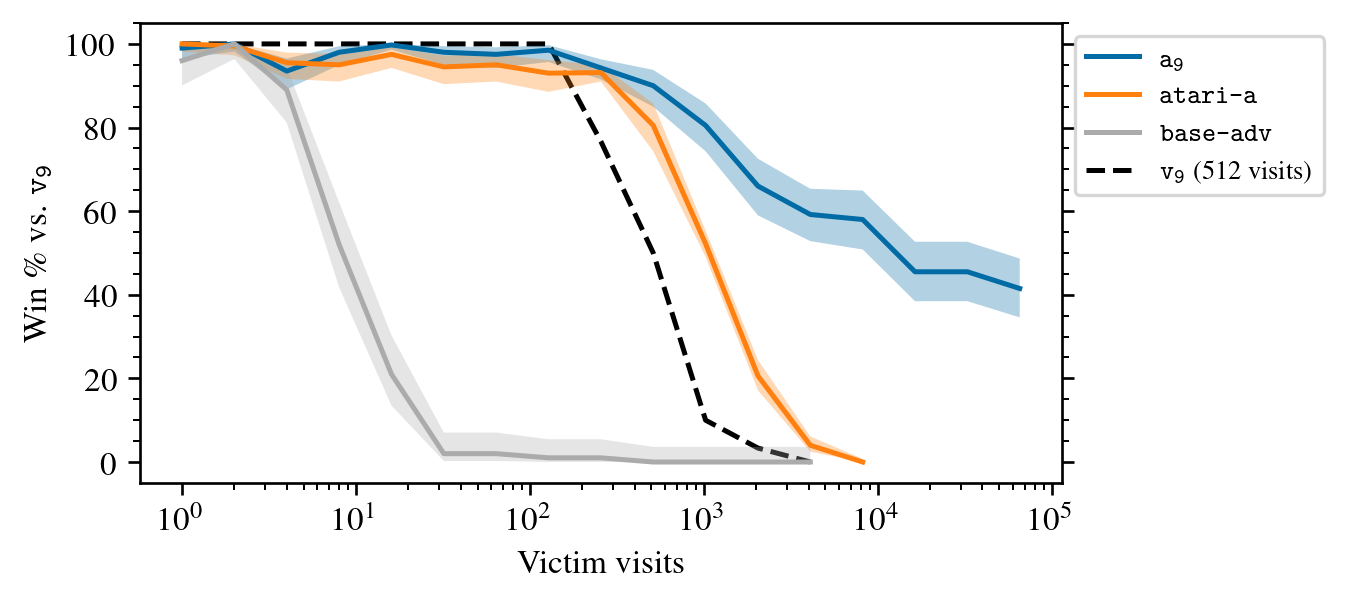

In [6]:
attack_h9_df = utils.parse_sgfs(["/shared/match/ttseng-attack-h9-240314/vs-h9"])
utils.parse_for_match(attack_h9_df, adv_name_regex="attack-h9")

r9_df = utils.parse_sgfs(["/shared/match/ttseng-rs-vs-hs-240119/r9-vs-h9"])
# Only get games against h9
r9_df = filter_df_for_player(r9_df, "h9")
utils.parse_for_match(r9_df, adv_name_regex="r9")

original_cyclic_df = utils.parse_sgfs(["/shared/match/ttseng-rs-vs-hs-240119/job-1"])
# Only get games against h9
original_cyclic_df = filter_df_for_player(original_cyclic_df, "h9")
utils.parse_for_match(original_cyclic_df, adv_name_regex="r0-v600")

fig, ax = plot_victim_visit_sweep(
    [
        (r9_df, r"\attackiter{9}"),
        (attack_h9_df, r"\attackhnineshort{}"),
        (original_cyclic_df, r"\origcyclicmedium{}"),
    ],
    r"\defenseiter{9}",
)

(100 * h9_self_wr).plot(
    ax=ax,
    label=rf"\defenseiter{{{9}}} ({target_visits} visits)",
    color="black",
    linestyle="--",
    zorder=-10,
)

ax.legend(loc="upper left", bbox_to_anchor=(1, 1))
fig.savefig("h9-icr.pgf", backend="pgf")

### b18

In [7]:
b18_df = utils.parse_sgfs(
    [f"/shared/match/paper-robustness/elo/b18-s8527m/{i}" for i in range(3)]
).query(
    'b_name.str.contains("b18-s8527m") and w_name.str.contains("b18-s8527m")'
)

print(len(b18_df))
b18_df.head(1)

2349


,b_name,w_name,victim_color,victim_name,victim_visits,victim_steps,victim_rsym,victim_algo,adv_color,adv_name,...,has_button,whb,fpok,init_turn_num,used_initial_position,gtype,is_continuation,is_resignation,sgf_path,sgf_line
2,b18-s8527m-v4,b18-s8527m-v512,w,b18-s8527m-v512,512,8527m,1,MCTS,b,b18-s8527m-v4,...,False,0,False,0,False,normal,False,False,/shared/match/paper-robustness/elo/b18-s8527m/...,3


In [8]:
target_visits = 512
assert (
    len(b18_df.query("victim_visits == @target_visits and adv_visits == @target_visits"))
    == 0
)

sub_df1 = b18_df.query("victim_visits == @target_visits").copy()
sub_df1["opp_visits"] = sub_df1["adv_visits"]
sub_df1["target_won"] = ~sub_df1["adv_win"]

sub_df2 = b18_df.query("adv_visits == @target_visits").copy()
sub_df2["opp_visits"] = sub_df2["victim_visits"]
sub_df2["target_won"] = sub_df2["adv_win"]

sub_df = pd.concat([sub_df1, sub_df2])[["target_won", "opp_visits"]]

b18_self_wr = sub_df.groupby("opp_visits").target_won.mean().copy()
b18_self_wr = pd.concat([b18_self_wr, pd.Series([0.5], index=[target_visits])])
b18_self_wr = b18_self_wr.sort_index()
b18_self_wr

1        1.000000
2        1.000000
4        1.000000
8        1.000000
16       1.000000
32       1.000000
64       1.000000
128      0.966667
256      0.766667
512      0.500000
1024     0.164557
2048     0.051282
4096     0.062500
8192     0.000000
16384    0.000000
dtype: float64

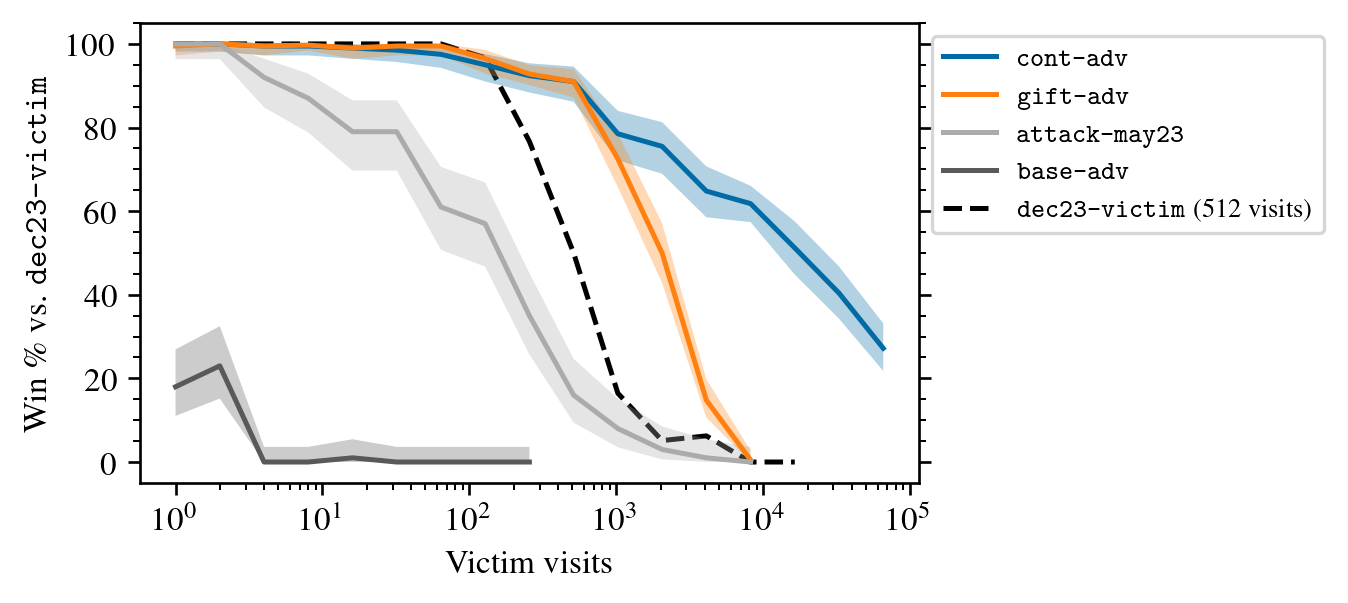

In [9]:
cont_df = utils.parse_sgfs(
    [
        "/shared/match/ttseng-cont-vs-b18-s8527m-240311/s630m-upto-v4096",
        "/shared/match/ttseng-cont-vs-b18-s8527m-240311/s630m-v8192-and-b60",
        "/shared/match/ttseng-cont-vs-b18-s8527m-240311/s630m-v16k-to-65k",
    ]
)
cont_df = filter_df_for_player(cont_df, "b18")
utils.parse_for_match(cont_df, adv_name_regex="cont")

ko_df = utils.parse_sgfs(["/shared/match/ttseng-attack-b18-240417/victim-visits"])
utils.parse_for_match(ko_df, adv_name_regex="attack-b18")

cyclic_df = utils.parse_sgfs(["/shared/match/ttseng-cont-vs-b18-s8527m-240311/cyclic"])
utils.parse_for_match(cyclic_df, adv_name_regex="r0-v600")

attack_b60_df = utils.parse_sgfs(
    ["/shared/match/ttseng-cont-vs-b18-s8527m-240311/attack-b60"]
)
utils.parse_for_match(attack_b60_df, adv_name_regex="attack-b60")

fig, ax = plot_victim_visit_sweep(
    [
        (cont_df, r"\contadvmedium{}"),
        (ko_df, r"\koadvmedium{}"),
        (attack_b60_df, r"\attackbsixty{}"),
        (cyclic_df, r"\origcyclicmedium{}"),
    ],
    r"\dectwentythree{}",
)

(100 * b18_self_wr).plot(
    ax=ax,
    label=rf"\dectwentythree{{}} ({target_visits} visits)",
    color="black",
    linestyle="--",
    zorder=-10,
)

ax.legend(loc="upper left", bbox_to_anchor=(1, 1))
fig.savefig("b18-icr.pgf", backend="pgf")

### ViT

In [10]:
vit_df = utils.parse_sgfs(["/shared/match/paper-robustness/elo/vit"]).query(
    'b_name.str.contains("vit-b16-s650025472")'
    ' and w_name.str.contains("vit-b16-s650025472")'
)

print(len(vit_df))
vit_df.head(1)

3960


,b_name,w_name,victim_color,victim_name,victim_visits,victim_steps,victim_rsym,victim_algo,adv_color,adv_name,...,has_button,whb,fpok,init_turn_num,used_initial_position,gtype,is_continuation,is_resignation,sgf_path,sgf_line
2,vit-b16-s650025472-v32768,vit-b16-s650025472-v32768,w,vit-b16-s650025472-v32768,32768,650025472,1,MCTS,b,vit-b16-s650025472-v32768,...,False,0,False,0,False,normal,False,False,/shared/match/paper-robustness/elo/vit/shared-...,3


In [11]:
target_visits = 512
assert (
    len(vit_df.query("victim_visits == @target_visits and adv_visits == @target_visits"))
    == 0
)

sub_df1 = vit_df.query("victim_visits == @target_visits").copy()
sub_df1["opp_visits"] = sub_df1["adv_visits"]
sub_df1["target_won"] = ~sub_df1["adv_win"]

sub_df2 = vit_df.query("adv_visits == @target_visits").copy()
sub_df2["opp_visits"] = sub_df2["victim_visits"]
sub_df2["target_won"] = sub_df2["adv_win"]

sub_df = pd.concat([sub_df1, sub_df2])[["target_won", "opp_visits"]]

vit_self_wr = sub_df.groupby("opp_visits").target_won.mean().copy()
vit_self_wr = pd.concat([vit_self_wr, pd.Series([0.5], index=[target_visits])])
vit_self_wr = vit_self_wr.sort_index()
vit_self_wr

1        1.000000
2        1.000000
4        1.000000
8        1.000000
16       1.000000
32       1.000000
64       1.000000
128      1.000000
256      0.806452
512      0.500000
1024     0.088235
2048     0.032258
4096     0.000000
8192     0.000000
16384    0.000000
32768    0.000000
dtype: float64

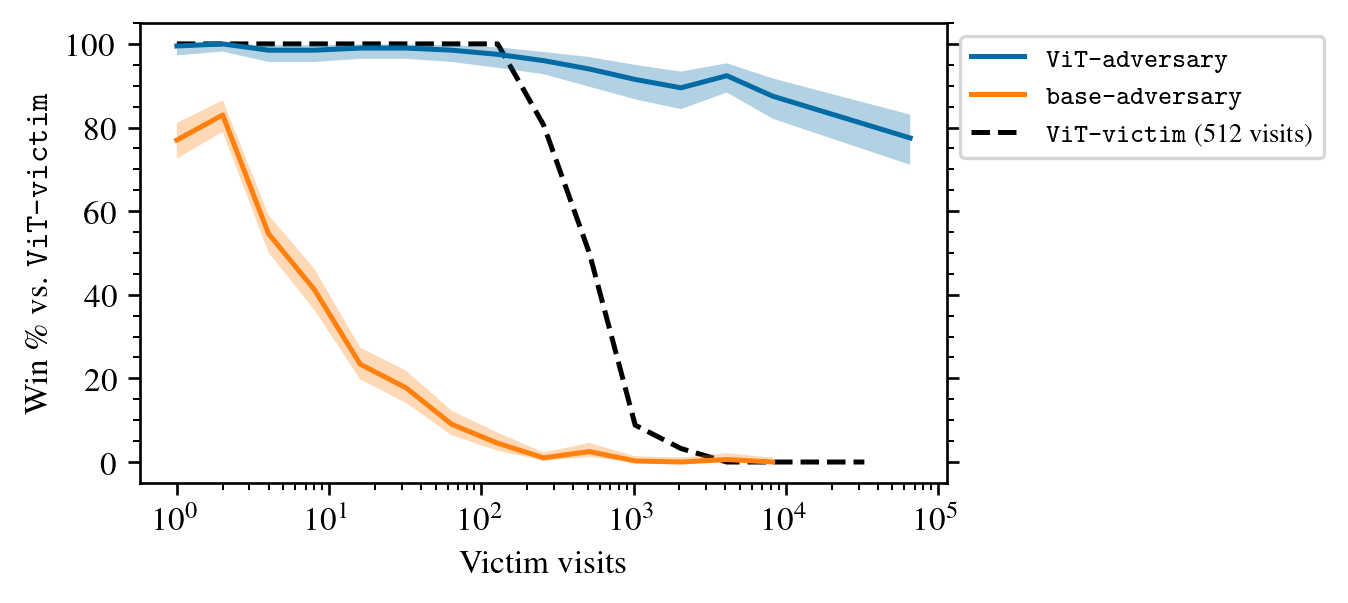

In [12]:
attack_vit_df = utils.parse_sgfs(
    ["/shared/match/ttseng-attack-vit-240311/v1-to-v8192-and-v65536"]
)
utils.parse_for_match(attack_vit_df, adv_name_regex="attack-vit")

original_cyclic_df = utils.parse_sgfs(["/shared/match/ttseng-vitb16-vs-cyclic"])
utils.parse_for_match(original_cyclic_df, adv_name_regex="cyclic")

fig, ax = plot_victim_visit_sweep(
    [
        (attack_vit_df, r"\vitadversary{}"),
        (original_cyclic_df, r"\origcyclic{}"),
    ],
    r"\vitvictim{}",
)

(100 * vit_self_wr).plot(
    ax=ax,
    label=rf"\vitvictim{{}} ({target_visits} visits)",
    color="black",
    linestyle="--",
    zorder=-10,
)

ax.legend(loc="upper left", bbox_to_anchor=(1, 1))
fig.savefig("vs-visits-vit.pgf", backend="pgf")